In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd 
from IPython.display import display
import textwrap
import json 
from gensim import corpora
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
from tqdm import tqdm
from collections import Counter
import numpy as np
from gensim.models import LdaModel
import matplotlib.pyplot as plt

## Import speech dataset and preprocessed data for lda

In [3]:
filename = "data/parllaw/speech_translated.csv"

df = pd.read_csv(filename)
df["year"] = df.apply(lambda s: int(s["date"][:4]), axis=1)
df["uq_agenda"] = df["agenda"]+df["date"]

In [4]:
# import preprocessed data: tokenization, lemmatization, stopword removal
preprocessed_data = json.load(open("data/lda/preprocessed_texts_all_translated.json"))

## Adjust party variable

In [5]:
# remove all speakers without clear political affiliation:

# only use speeches where speaker is associated with a party
df_party_members = df[~(df["party"] == "-")]
# remove non-inscrits: no party group affiliation
# df_party_members = df_party_members[~(df_party_members["party"] == "NI")]
# remove TGI: technical group of independents, no party group affiliation
# df_party_members = df_party_members[~(df_party_members["party"] == "TGI")]

# only keep speeches with at least 50 characters: important for coherence with preprocessed data
df_party_members = df_party_members[df_party_members["translatedText"].map(str).map(len) > 50]
print(len(df_party_members))
assert len(df_party_members) == len(preprocessed_data)

505705


In [6]:
# merge parties that changed names over time
df_party_members['party_adj'] = df_party_members['party']  # start with a copy

df_party_members.loc[df_party_members['party'].isin(['PSE', 'S&D']), 'party_adj'] = 'PSE/S&D' # PSE becomes S&D
df_party_members.loc[df_party_members['party'].isin(['PPE-DE', 'PPE']), 'party_adj'] = 'PPE' # PPE-DE' becomes 'PPE'
df_party_members.loc[df_party_members['party'].isin(['EFDD', 'EFD']), 'party_adj'] = 'EFD' # 'EFDD' becomes 'EFD'
df_party_members.loc[df_party_members['party'].isin(['ITS', 'ENF', 'ID']), 'party_adj'] = 'ENF/ID' # ENF becomes ID in 2019
df_party_members.loc[df_party_members['party'].isin(['ELDR','ALDE', 'Renew']), 'party_adj'] = 'ELDR/ALDE/Renew' # ELDR becomes ALDE becomes Renew
df_party_members.loc[df_party_members['party'].isin(['GUE/NGL','The Left']), 'party_adj'] = 'NGL/The Left' # GUE/NGL becomes The Left
df_party_members.loc[df_party_members['party'].isin(['IND/DEM','EDD']), 'party_adj'] = 'INDDEM/EDD' # independents become EDD

# print information
display(df_party_members["party_adj"].value_counts())

party_adj
PPE                162460
PSE/S&D            119501
NGL/The Left        46465
ELDR/ALDE/Renew     42610
ECR                 29222
Greens/EFA          26260
NI                  26147
EFD                 22172
ENF/ID              20787
UEN                  5171
INDDEM/EDD           4436
TGI                   474
Name: count, dtype: int64

In [7]:
# add column: party block
df_party_members['party_block'] = df_party_members['party']  # start with a copy

# left
df_party_members.loc[df_party_members['party'].isin(['GUE/NGL','The Left']), 'party_block'] = 'left'
# green
df_party_members.loc[df_party_members['party'].isin(['Greens/EFA']), 'party_block'] = 'greens'
# social democratic
df_party_members.loc[df_party_members['party'].isin(['PSE', 'S&D']), 'party_block'] = 'social_democratic'
# christian conservative
df_party_members.loc[df_party_members['party'].isin(['PPE-DE', 'PPE']), 'party_block'] = 'christian_conservative'
# liberal
df_party_members.loc[df_party_members['party'].isin(['ELDR','ALDE', 'Renew']), 'party_block'] = 'liberal'
# right populist
df_party_members.loc[df_party_members['party'].isin(['EFDD', 'EFD','ITS', 'ENF', 'ID', 'IND/DEM', 'ECR', 'UEN', 'EDD']), 'party_block'] = 'right_populist'

# print information
display(df_party_members["party_block"].value_counts())

party_block
christian_conservative    162460
social_democratic         119501
right_populist             81788
left                       46465
liberal                    42610
greens                     26260
NI                         26147
TGI                          474
Name: count, dtype: int64

In [8]:
# save df_party_members to csv
# df_party_members.to_csv("data/csv/speech_output_parties.csv", index=False)

### We still need to translate speeches post 2019: how many? 

In [9]:
# df_untranslated = df_party_members[df_party_members["translatedText"].isna()]
# df_untranslated.head()

# # compute number of speeches to be translated
# num_speeches = df_untranslated.shape[0]
# print(f"Number of speeches to be translated: {num_speeches}")

# # compute number of speeches already translated
# num_speeches_translated = df_party_members.shape[0]
# print(f"Number of speeches already translated: {num_speeches_translated}")

# # compute number of characters in untranslated speeches
# total_chars = df_untranslated["text"].apply(len).sum()
# print(f"Total characters to be translated: {total_chars}")

# total_chars_translated = df_party_members["text"].apply(len).sum()
# print(f"Total characters already translated: {total_chars_translated}")

In [10]:
# # for now: only use speeches which were given in english or machine translation availible
# df_party_members = df_party_members[df_party_members["translatedText"].notna()]

In [11]:
# synchronize preprocessed_data with df_party_members by filtering to matching indices
# create a boolean mask based on the original df indices
# original_indices = df.index.tolist()
# kept_indices_set = set(df_party_members.index.tolist())
# mask = [i in kept_indices_set for i in original_indices]
# preprocessed_data = [preprocessed_data[i] for i, keep in enumerate(mask) if keep]
# print(f"Filtered preprocessed_data to {len(preprocessed_data)} entries")
# print(f"df_party_members has {len(df_party_members)} rows")
# print(f"Lengths match: {len(preprocessed_data) == len(df_party_members)}")

# df_party_members = df_party_members.reset_index(drop=True)

In [12]:
df_party_members = df_party_members.reset_index(drop=True)

## LDA: Define 80 (for now) topics and assign their probabilities to each speech

In [13]:
print("creating dictionary")
dictionary = corpora.Dictionary(preprocessed_data)
print("filtering dictionary")
dictionary.filter_extremes(
    no_below=10,     # Keep tokens appearing in at least 10 docs
    no_above=0.4,    # Remove tokens appearing in more than 40% of docs
    keep_n=100000    # Keep only the top 100k words by frequency
)
corpus = [dictionary.doc2bow(l) for l in tqdm(preprocessed_data, "Preparing corpus")]

creating dictionary
filtering dictionary


Preparing corpus: 100%|██████████| 505705/505705 [00:26<00:00, 19039.91it/s]


In [14]:
def print_topics(model, n_topics, k_words=5):
    for idx, topic in model.show_topics(formatted=False, num_topics=n_topics):
        label = ", ".join([word for word, prob in topic[:k_words]])
        print(f"Topic {idx + 1}: {label}")

In [15]:
def assign_topics(lda_model, corpus):
    # choose the LDA model to use (change if you want a different one)
    topics = []
    for bow in tqdm(corpus, desc="Assigning most probable topic to each doc"):
        docs_topics = lda_model.get_document_topics(bow, minimum_probability=0)
        topics.append(docs_topics)
    return topics

## Assign topics to speeches using pre-trained model

In [46]:
n_topics = 120
model = LdaModel.load(f"data/lda/{n_topics}_topics/5/model.model")

corpus_topics = assign_topics(model, corpus)
# set up df with topic probabilities

# corpus topics is a list of lists of (topic_id, probability) tuples for each document in the corpus
# turn this list into dataframe of size (num_docs, num_topics) with probabilities
num_docs = len(corpus_topics)
num_topics = n_topics
topic_prob_matrix = np.zeros((num_docs, num_topics))
for doc_idx, doc_topics in enumerate(corpus_topics):
    for topic_id, prob in doc_topics:
        topic_prob_matrix[doc_idx, topic_id] = prob
topic_prob_df = pd.DataFrame(topic_prob_matrix, columns=[f"topic_{i}" for i in range(num_topics)])

# append topic probabilities to df_party_members
df_topics = pd.concat([df_party_members.reset_index(drop=True), topic_prob_df], axis=1)

# exlude "NI" and "TGI" from party columns, these are non-inscrits without party group affiliation
df_topics = df_topics[~df_topics["party"].isin(["NI", "TGI"])]

Assigning most probable topic to each doc: 100%|██████████| 505705/505705 [03:36<00:00, 2336.43it/s]


In [76]:
# print list of topics
print_topics(model, n_topics)

Topic 1: people, government, prodi, party, hungarian
Topic 2: emission, reduce, car, co, reduction
Topic 3: energy, supply, gas, renewable, efficiency
Topic 4: parliament, citizen, treaty, institution, lisbon
Topic 5: system, india, river, satellite, prompt
Topic 6: people, poverty, social, live, population
Topic 7: barroso, chair, vice, pakistan, suspend
Topic 8: group, amendment, parliament, vote, mr
Topic 9: eu, ireland, government, british, people
Topic 10: woman, man, equality, gender, equal
Topic 11: cultural, culture, diversity, value, tradition
Topic 12: space, aircraft, incident, brazil, frontier
Topic 13: euro, rate, debt, bank, central
Topic 14: mr, commission, commissioner, question, council
Topic 15: indonesia, unclear, helsinki, disagreement, danube
Topic 16: vote, report, favour, resolution, favor
Topic 17: education, training, professional, school, skill
Topic 18: peace, conflict, international, israel, un
Topic 19: disaster, solidarity, damage, cause, natural
Topic 20:

In [77]:
# enter topic id of interest
topic_id = 105

## Investigate topic of interest

In [78]:
# return first 10 words and their probabilities for topic of interest
topic_terms = model.get_topic_terms(topicid=topic_id, topn=10)
terms_with_words = [(dictionary[id], prob) for id, prob in topic_terms]
print(f"Topic {topic_id} terms:")
for word, prob in terms_with_words:
    print(f"  {word}: {prob:.4f}")
# save first three words
first_3_words = [dictionary[id] for id, prob in topic_terms[:3]]

# set up dataset with only speeches related to that topic
prob_threshold = 0.25
df_selected_topic = df_topics[df_topics[f"topic_{topic_id}"] >= prob_threshold]
print(f"Number of speeches in topic {topic_id} ({first_3_words}) with prob >= {prob_threshold}): {df_selected_topic.shape[0]}")

Topic 105 terms:
  immigration: 0.0488
  asylum: 0.0449
  refugee: 0.0411
  country: 0.0313
  immigrant: 0.0273
  migration: 0.0257
  policy: 0.0210
  illegal: 0.0191
  migrant: 0.0184
  people: 0.0176
Number of speeches in topic 105 (['immigration', 'asylum', 'refugee']) with prob >= 0.25): 5871


In [79]:
# 5 speeches just above threshold
print(f"Just passing speeches for topic {topic_id} ({first_3_words}):\n")
df_selected_topic_sorted = df_selected_topic.sort_values(by=f"topic_{topic_id}")
speech_number = 5
for i in range(speech_number):
    speech = df_selected_topic_sorted.iloc[i]
    print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
    print(textwrap.fill(speech["translatedText"], width=80))
    print("\n" + "-"*80 + "\n")

Just passing speeches for topic 105 (['immigration', 'asylum', 'refugee']):

Speech 1 with topic probability 0.2500:
I am also a new MEP from Poland. I am a lawyer specializing in maritime law.
What my colleague just said is terrible and inhumane. Do you believe that we,
Europeans, are different, better people than refugees from Africa? Could we be
rescued in the Mediterranean Sea, but not refugees from countries in need? Where
are our European, fundamental, Christian values?

--------------------------------------------------------------------------------

Speech 2 with topic probability 0.2500:
I have voted for the report on the Council position on Draft amending budget No
8/2015 of the European Union for the financial year 2015, Own resources and
European Data Protection Supervisor because it was noted that further financial
efforts will be needed to provide humanitarian assistance along the transit
routes and to manage the challenges posed by the reception of unprecedented
numbers 

In [80]:
# top 5 speeches with highest probability
print(f"Top speeches for topic {topic_id} ({first_3_words}):\n")
df_selected_topic_sorted_desc = df_selected_topic.sort_values(by=f"topic_{topic_id}", ascending=False)
speech_number = 5
for i in range(speech_number):
    speech = df_selected_topic_sorted_desc.iloc[i]
    print(f"Speech {i+1} with topic probability {speech[f'topic_{topic_id}']:.4f}:")
    print(textwrap.fill(speech["translatedText"], width=80))
    print("\n" + "-"*80 + "\n")

Top speeches for topic 105 (['immigration', 'asylum', 'refugee']):

Speech 1 with topic probability 0.9504:
Given the current number of asylum seekers in Greece and the increasing number
of asylum seekers arriving in Italy, I believe that there will remain a high
demand for emergency relocation places.

--------------------------------------------------------------------------------

Speech 2 with topic probability 0.8847:
I supported. The last weeks have shown that the European asylum system is not
working as it should. Europe has not been able to humanely deal with war
refugees, but the refugee crisis is manageable and the European Union can handle
it humanely if all countries help.

--------------------------------------------------------------------------------

Speech 3 with topic probability 0.7767:
Colleague, the most effective way to address traffickers and fight smugglers is
to open legal and safe ways for refugees.

------------------------------------------------------------

In [81]:
# create color legend for party blocks
party_block_colors = {
    'left': 'purple',
    'greens': 'green',
    'social_democratic': 'red',
    'christian_conservative': 'black',
    'liberal': 'orange',
    'right_populist': 'blue'
}

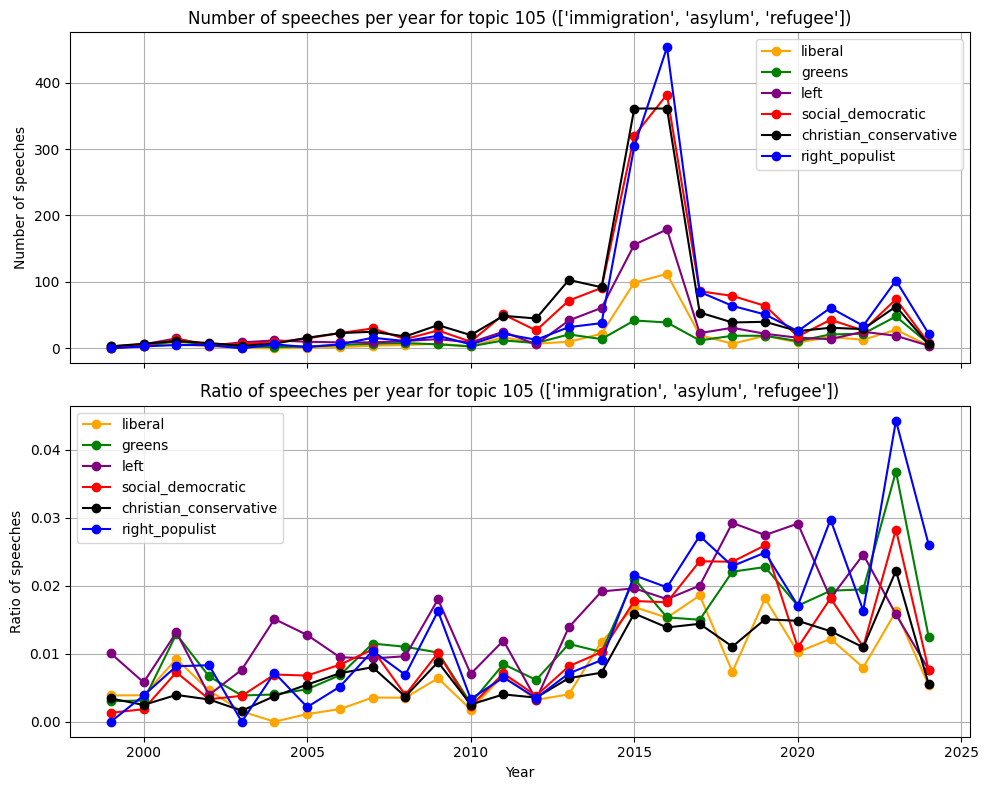

In [82]:
# plots: number and ratio of speeches per year and party block
party_blocks = df_selected_topic['party_block'].unique()
years = sorted(df_selected_topic['year'].unique())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
for party_block in party_blocks:
    counts_per_year = []
    normalized_counts_per_year = []
    for year in years:
        count = df_selected_topic[(df_selected_topic['party_block'] == party_block) & (df_selected_topic['year'] == year)].shape[0]
        counts_per_year.append(count)
        total_count = df_topics[(df_topics['party_block'] == party_block) & (df_topics['year'] == year)].shape[0]
        normalized_count = count / total_count if total_count > 0 else 0
        normalized_counts_per_year.append(normalized_count)
    ax1.plot(years, counts_per_year, label=party_block, marker='o', color=party_block_colors.get(party_block))
    ax2.plot(years, normalized_counts_per_year, label=party_block, marker='o', color=party_block_colors.get(party_block))
ax1.set_title(f"Number of speeches per year for topic {topic_id} ({first_3_words})")
ax1.set_ylabel("Number of speeches")
ax1.legend()
ax2.set_title(f"Ratio of speeches per year for topic {topic_id} ({first_3_words})")
ax2.set_ylabel("Ratio of speeches")
ax2.set_xlabel("Year")
ax2.legend()
ax1.grid(True)
ax2.grid(True)
plt.tight_layout()
plt.show()

### basic interpretation: topic 9 is more neutral refugee, topic 39 is more related to the situation in italy, and more pushed by right-wing populists

In [54]:
# # get migration dataset
# topic_id_migration_neutral = 8
# topic_id_migration_italy = 39
# df_migration_neutral = df_topics[df_topics[f"topic_{topic_id_migration_neutral}"] >= prob_threshold]
# print(f"Number of speeches in topic migration_neutral (topic {topic_id_migration_neutral} with prob >= {prob_threshold}): {df_migration_neutral.shape[0]}")
# df_migration_italy = df_topics[df_topics[f"topic_{topic_id_migration_italy}"] >= prob_threshold]
# print(f"Number of speeches in topic migration_italy (topic {topic_id_migration_italy} with prob >= {prob_threshold}): {df_migration_italy.shape[0]}")

### Test: Display migration speeches with lowest probability that is still above threshold

In [55]:
# df_migration_sorted_neutral = df_migration_neutral.sort_values(by=f"topic_{topic_id_migration_neutral}")
# speech_number = 10
# print("Just passing speeches for migration_neutral topic:")
# for idx, row in df_migration_sorted_neutral.head(speech_number).iterrows():
#     print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_neutral}']:.4f}")
#     print(textwrap.fill(row["translatedText"], width=100))
#     print("\n" + "-"*100 + "\n")

In [56]:
# df_migration_sorted_italy = df_migration_italy.sort_values(by=f"topic_{topic_id_migration_italy}")
# speech_number = 10
# print("Just passing speeches for migration_italy topic:")
# for idx, row in df_migration_sorted_italy.head(speech_number).iterrows():
#     print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_italy}']:.4f}")
#     print(textwrap.fill(row["translatedText"], width=100))
#     print("\n" + "-"*100 + "\n")

### Test: Display speeches with highest probability

In [57]:
# df_migration_sorted_neutral = df_migration_neutral.sort_values(by=f"topic_{topic_id_migration_neutral}", ascending=False)
# speech_number = 10
# print("Top speeches for migration_neutral topic:")
# for idx, row in df_migration_sorted_neutral.head(speech_number).iterrows():
#     print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_neutral}']:.4f}")
#     print(textwrap.fill(row["translatedText"], width=100))
#     print("\n" + "-"*100 + "\n")

In [58]:
# df_migration_sorted_italy = df_migration_italy.sort_values(by=f"topic_{topic_id_migration_italy}", ascending=False)
# speech_number = 10
# print("Top speeches for migration_italy topic:")
# for idx, row in df_migration_sorted_italy.head(speech_number).iterrows():
#     print(f"Year: {row['year']}, Topic Probability: {row[f'topic_{topic_id_migration_italy}']:.4f}")
#     print(textwrap.fill(row["translatedText"], width=100))
#     print("\n" + "-"*100 + "\n")

In [59]:
# # save combined migration data to csv
# df_migration = pd.concat([df_migration_neutral, df_migration_italy]).drop_duplicates().reset_index(drop=True)
# df_migration = df_migration_neutral
# df_migration.to_csv("migration_speeches_lda.csv", sep="\t")

In [60]:
# # plot number of speeches in topic 9 and 39 per year
# migration_neutral_counts_per_year = df_migration_neutral['year'].value_counts().sort_index()
# migration_italy_counts_per_year = df_migration_italy['year'].value_counts().sort_index()
# plt.figure(figsize=(8, 4))
# plt.plot(migration_neutral_counts_per_year.index, migration_neutral_counts_per_year.values, marker='o', label='Migration Neutral (Topic 9)')
# plt.plot(migration_italy_counts_per_year.index, migration_italy_counts_per_year.values, marker='o', label='Migration Italy (Topic 39)')
# plt.title('Number of Migration-Related Speeches per Year')
# plt.xlabel('Year')
# plt.ylabel('Number of Speeches')
# plt.legend()
# plt.grid()
# plt.show()

In [61]:
# # normalized plot: ratio of migration speeches to total speeches per year
# speech_counts_per_year = df_party_members['year'].value_counts().sort_index()
# ratio_neutral_per_year = migration_neutral_counts_per_year / speech_counts_per_year
# ratio_neutral_per_year = ratio_neutral_per_year.dropna()  # remove NaN values
# ratio_italy_per_year = migration_italy_counts_per_year / speech_counts_per_year
# ratio_italy_per_year = ratio_italy_per_year.dropna()  # remove NaN values
# plt.figure(figsize=(6, 4))
# plt.plot(ratio_neutral_per_year.index, ratio_neutral_per_year.values, marker='o', label='Migration Neutral (Topic 9)')
# plt.plot(ratio_italy_per_year.index, ratio_italy_per_year.values, marker='o', label='Migration Italy (Topic 39)')
# plt.title('Ratio of Migration-Related Speeches per Year')
# plt.xlabel('Year')
# plt.ylabel('Ratio of Speeches')
# plt.legend()
# plt.grid()
# plt.show()

In [62]:
# # Create figure with 3 subplots
# fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# # Define datasets and titles
# datasets = [
#     (df_migration, 'Migration_Combined'),
#     (df_migration_neutral, 'Migration_Neutral'),
#     (df_migration_italy, 'Migration_Italy')
# ]

# # Plot each dataset
# for ax, (data, title) in zip(axes, datasets):
#     for party_block in data['party_block'].unique():
#         party_block_data = data[data['party_block'] == party_block]
#         counts_per_year = party_block_data['year'].value_counts().sort_index()
#         ax.plot(counts_per_year.index, counts_per_year.values, marker='o', 
#                 label=party_block, color=party_block_colors.get(party_block))
    
#     ax.set_title(f'Number of {title} Speeches per Year by Party Block')
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Number of Speeches')
#     ax.legend()
#     ax.grid()

# plt.tight_layout()
# plt.show()


In [63]:
# # Create single figure with all three migration datasets
# fig, axes = plt.subplots(3, 1, figsize=(10, 12))

# # Define datasets and titles
# datasets = [
#     (df_migration, 'Migration_Combined'),
#     (df_migration_neutral, 'Migration_Neutral'),
#     (df_migration_italy, 'Migration_Italy')
# ]

# # Plot each dataset
# for ax, (data, title) in zip(axes, datasets):
#     for party_block in data['party_block'].unique():
#         party_block_data = data[data['party_block'] == party_block]
#         counts_per_year = party_block_data['year'].value_counts().sort_index()
#         total_counts_per_year = df_party_members[df_party_members['party_block'] == party_block]['year'].value_counts().sort_index()
#         ratio_per_year = counts_per_year / total_counts_per_year
#         ratio_per_year = ratio_per_year.dropna()
#         ax.plot(ratio_per_year.index, ratio_per_year.values, marker='o', 
#                 label=party_block, color=party_block_colors.get(party_block))
    
#     ax.set_title(f'Ratio of {title} Speeches per Year by Party Block')
#     ax.set_xlabel('Year')
#     ax.set_ylabel('Ratio of Speeches')
#     ax.legend()
#     ax.grid()

# plt.tight_layout()
# plt.show()


## Old approach: Use Keyword search to find relevant agendas / speeches

In [64]:
# keywords = ["(M|m)igration", "(M|m)igrant", "(R|r)efugee", "(A|a)sylum", "(T|t)hird(-)?country national"]#, "(F|f)rontex"]
# indices_keyword_identified_speeches = df_party_members.index[df_party_members["uq_agenda"].str.contains("|".join(keywords))].tolist()
# TODO: potentially find relevant keywords using word2vec over text and look for words similar to migration? 

In [65]:
# def filter_for_keywords(df, column="agenda", keywords=keywords, min_contributions_per_agenda_item=10): 
#     relevant_indices = df[column].str.contains("|".join(keywords))
#     agenda_items_vc = df[relevant_indices]["uq_agenda"].value_counts()
    
#     # TODO: do this filtering in the beginning because why not
#     n_agenda_items_before = len(agenda_items_vc)
#     relevant_agendas = agenda_items_vc[agenda_items_vc > min_contributions_per_agenda_item]
#     n_agenda_items_after = len(relevant_agendas)
#     print(f"filtered {n_agenda_items_before-n_agenda_items_after} agenda items with < {min_contributions_per_agenda_item} speeches")
    
#     relevant_indices = relevant_indices & (df["uq_agenda"].isin(relevant_agendas.index))
    
#     print(f"n speeches: {len(df[relevant_indices])}")
#     print(f"n agendas: {n_agenda_items_after}")
    
#     return df[relevant_indices]

In [66]:
# # agenda items per year; speech per year; 
# # party per agenda item
# # contribution per party per year
# # normalize by original 
# df_filtered = filter_for_keywords(df)

In [67]:
# n_per_year_and_party = df_filtered.groupby(["year"]).size()#.unstack()

# ax = n_per_year_and_party.plot(kind="bar", stacked=False, figsize=(40, 5))
# shortened_labels = [l[:50]+"..." if len(l) > 50 else l for l in [lb.get_text() for lb in ax.get_xticklabels()]]
# _ = ax.set_xticklabels(shortened_labels)

In [68]:
# vc = df_filtered["uq_agenda"].value_counts()
# vc

In [69]:
# df_filtered_text = filter_for_keywords("text")

In [70]:
# n = df_filtered_text["uq_agenda"].value_counts()
# print(n.min(), n.mean(), n.max())

# #df_filtered["uq_agenda"]
# print(len(n))
# # agendas that with more than 4 speeches with relevant keywords, that are not in the agendas that were discovered with keywords in title
# new_relevant_agendas = n[(n>4) & (~n.index.isin(df_filtered["uq_agenda"]))]
# new_relevant_agendas[:20]

In [71]:
# def print_agenda(search_term, n_speeches=None): 
#     all_agendas = df[df["uq_agenda"].str.contains(search_term)]["uq_agenda"].unique()
#     for agenda in all_agendas: 
#         speeches = df[df["uq_agenda"] == agenda].sort_values(by="speechnumber", ascending=True)
#         print("Agenda:", (agenda[:30]+"..." if len(agenda) > 30 else agenda))
#         print("Nr of speeches:", len(speeches))
#         print("")
        
#         if n_speeches:
#             speeches = speeches[:n_speeches]
#         for _, r in speeches.iterrows(): 
#             print(f'({r["speechnumber"]}) {r["speaker"]} ({r['party']}): {r['text'] if not r['translatedText'] else r["translatedText"]}')

In [72]:
# print_agenda("6.4. Situation of fundamental rights in the European Union in 2015", 10)
# print_agenda("7.7. The situation of women refugees and asylum seekers in the EU", 10)
# print_agenda("European Border and Coast Guard", 10)

## Model evaluation

In [73]:
# def evaluate_model(lda_model, dictionary, compute_coherence=True): 
#     if compute_coherence: 
#         print("Computing coherence")
#         coherence_model = CoherenceModel(
#             model=lda_model, 
#             texts=preprocessed_data, 
#             dictionary=dictionary, 
#             coherence='c_v'  # most common coherence measure
#         )
#         coherence_score = coherence_model.get_coherence()
#         print("Coherence:", coherence_score)
#     else: 
#         coherence_score = None 
        
#     # compute which topics are related to migration 
#     migration_topic_indices = lda_model.get_term_topics(lda_model.id2word.token2id["migration"], minimum_probability=0)
#     print("Topics related to 'migration':", len(migration_topic_indices))
    
#     # check if any migration-related topic has probability > 0.05 (arbitrary threshold)
#     threshold = 0.05
#     high_topics = [(tid, prob) for tid, prob in migration_topic_indices if prob > threshold]
#     if len(high_topics) > 0:
#         print(f"Topics with probability > {threshold}: {high_topics}")
#     else:
#         print(f"No migration-related topic has probability > {threshold}")

#     # for each speech with migration-keyworded agenda, get most probable topic
#     topic_counts = Counter()
#     topic_probabilities = []
#     missmatches = 0 
#     for idx in indices_keyword_identified_speeches:
#         # if idx >= len(preprocessed_data):
#         #     break
#         bow = dictionary.doc2bow(preprocessed_data[idx])
#         topic_distribution = lda_model.get_document_topics(bow)
#         most_probable_topic = max(topic_distribution, key=lambda x: x[1])
#         topic_counts[most_probable_topic[0]] += 1
#         topic_probabilities.append(most_probable_topic[1])

#         if most_probable_topic[0] not in dict(migration_topic_indices):
#             missmatches += 1 # count how often the most probable topic is not a migration-related topic

#     print("Most common topics for migration-related speeches:", topic_counts.most_common(len(migration_topic_indices)))
#     print("Average probability of most probable topic for migration-related speeches:", sum(topic_probabilities) / len(topic_probabilities))
#     print("missmatches (most probable topic not migration-related):", missmatches, f"{missmatches / len(indices_keyword_identified_speeches):.2%}")

#     return len(high_topics), coherence_score, missmatches

In [74]:
# n_topic_values = [90, 100, 120]
# n_workers = 8

# import os 
# for n_topics in n_topic_values: 
#     os.makedirs(f"lda/{n_topics}_topics", exist_ok=True)
#     out_path = f"lda/{n_topics}_topics/model.model"
#     num_topics = n_topics
#     n_passes = 5
#     workers = n_workers

#     print("Fitting model with", num_topics, "topics and", n_passes, "passes")
#     lda_model = LdaMulticore(corpus = corpus, id2word=dictionary, num_topics = num_topics, passes = n_passes, workers=workers)
#     lda_model.save(out_path)

#     # Evaluate model
#     evaluate_model(lda_model, dictionary)

### Old Function: Count topic assignments

In [75]:
# def count_topic_assignments(corpus_topics, topic_id, prob_threshold=0.0):
#     total = 0
#     most_prob_count = 0
#     at_least_prob_count = 0

#     most_doc_indices = [] 

#     most_probabilities = []
#     at_least_probabilites = []
#     for i, doc_topics in tqdm(enumerate(corpus_topics), desc="Counting topic assignments"):
#         # skip empty entries
#         if not doc_topics:
#             continue
#         total += 1

#         most_topic, most_prob = max(doc_topics, key=lambda x: x[1])
#         if most_topic == topic_id:
#             most_prob_count += 1
#             most_probabilities.append(most_prob)
#             most_doc_indices.append(i)

#         # probability of the target topic (0.0 if absent)
#         prob_map = dict(doc_topics)
#         prob = prob_map.get(topic_id, 0.0)
#         if prob >= prob_threshold:
#             at_least_prob_count += 1
#             at_least_probabilites.append(prob)

#     if total == 0:
#         return ({
#             "total_docs": 0,
#             "most_prob_count": 0,
#             "at_least_prob_count": 0,
#             "most_avg_prob": 0.0, 
#             "at_least_avg_prob": 0.0,
#         }, [], [])

#     return ({
#         "total_docs": total,
#         "most_prob_count": most_prob_count,
#         "at_least_prob_count": at_least_prob_count, 
#         "most_avg_prob": sum(most_probabilities) / most_prob_count,
#         "at_least_avg_prob": sum(at_least_probabilites) / at_least_prob_count,  
#     }, most_doc_indices, most_probabilities)